<a href="https://colab.research.google.com/github/kruthi3012/anime-recommender/blob/main/anime_suggestor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation engine with a [graph](https://www.geeksforgeeks.org/graph-data-structure-and-algorithms/)
>The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.<br/> The more the measure is high, the closest are the two nodes.<br/> The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film

# How to take in account of the description?

#### First idea ...
> In order to take in account the description, the movie are clustered by applying a KMeans clustering with TF-IDF weights <br/> So two movies that belong in a group of description will share a node.<br/> The fewer the number of films in the group, the more this link will be taken into account

**but it doesn't work because clusters are too unbalanced*

#### Second idea ...
> In order to take in account the description, calcul the TF-IDF matrix <br/> and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.

I have publish a notebook that explains what is "KMeans clustering with TF-IDF" here :
https://www.kaggle.com/yclaudel/find-similar-articles-with-tf-idf

# Adamic Adar measure
It is a measure used to compute the closeness of nodes based on their shared neighbors.

* x and y are 2 nodes (2 Movies)
* N(one_node) is a function that return the set of adjacent nodes  to one_node

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$

<span>&#171;</span>say otherwise, for each node u in common to x and y, add to the measure 1/log(N(u))<span>&#187;</span>

The quantity $ \frac{1}{log(N(u))} $ determine the importance of u in the measure.
* if x and y share a node u that has a lot of adjacent nodes, this node is not really relevant. <span>&#8594;</span> N(u) is high <span>&#8594;</span> 1/log(N(u)) is not high
* if x and y share a node u that **does not** have a lot of adjacent nodes, this node is **really** relevant.<br/> <span>&#8594;</span> N(u) is **not** high <span>&#8594;</span> 1/log(N(u)) is higher

If “triangle closing” is a frequent mechanism by which new edges form in a social network, then for x and y to be introduced by a common friend z, person z will have to choose to introduce the pair ⟨x,y⟩ from
(choose |Γ(z)| with 2) pairs of his friends; thus an unpopular person (someone with not a lot of friends) may be more likely to introduce a particular pair of his friends to each other.

<img src="http://be.amazd.com/link-prediction/index_files/images/adamic-graph.png">

In [ ]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

<ipython-input-1-cbbd152d5869>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Load the data

In [ ]:
# load the data
df = pd.read_csv('/content/sample_data/anime.csv')
# convert to datetime
#df["date_added"] = pd.to_datetime(df['date_added'])
#df['year'] = df['date_added'].dt.year
#df['month'] = df['date_added'].dt.month
#df['day'] = df['date_added'].dt.day'''
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
#df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['genre'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
#df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
#df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,Unnamed: 0,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link,categories
0,0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...,"[Comedy, Sports, Drama, School, Shounen]"
1,1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...,"[Drama, Music, Romance, School, Shounen]"
2,2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]"
3,3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...,"[Action, Military, Adventure, Comedy, Drama, M..."
4,4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...,"[Action, Mystery, Supernatural, Vampire]"


In [ ]:
print(df.shape)

(15934, 14)


# KMeans clustering with [TF-IDF](https://monkeylearn.com/blog/what-is-tf-idf/)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['synopsis']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
df.synopsis=df.synopsis.fillna(' ')
#tfidf = vector.fit_transform(text_content)
tfidf = vector.fit_transform(df.synopsis)

# Clustering  Kmeans
k = 600
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

request_transform = vector.transform(df['synopsis'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

## [Cosine similarity](https://www.geeksforgeeks.org/cosine-similarity/)
is a metric, helpful in determining, how similar the data objects are irrespective of their size. We can measure the similarity between two sentences in Python using Cosine Similarity. In cosine similarity, data objects in a dataset are treated as a vector. <br/>
Formula: Cos(x, y) = x . y / ||x|| * ||y||

In [ ]:
# Find similar : get the top_n movies with description similar to the target description
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Category
* Country
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a category and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [ ]:
G = nx.Graph(label="ANIME")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['uid'],label="ANIME",ranking=rowi['ranked']) #mtype=rowi['type']
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    #for element in rowi['actors']:
        #G.add_node(element,label="PERSON")
        #G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="GEN")
        G.add_edge(rowi['title'], element, label="GEN_IN")
    #for element in rowi['directors']:
        #G.add_node(element,label="PERSON")
        #G.add_edge(rowi['title'], element, label="DIRECTED")
    #for element in rowi['countries']:
        #G.add_node(element,label="COU")
        #G.add_edge(rowi['title'], element, label="COU_IN")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

 iter 0 -- 0.021538257598876953 seconds --
 iter 1000 -- 11.53330659866333 seconds --
 iter 2000 -- 22.822733402252197 seconds --
 iter 3000 -- 34.88946008682251 seconds --
 iter 4000 -- 46.05977964401245 seconds --
 iter 5000 -- 57.49348187446594 seconds --
 iter 6000 -- 68.59703397750854 seconds --
 iter 7000 -- 79.68111991882324 seconds --
 iter 8000 -- 90.45310306549072 seconds --
 iter 9000 -- 101.15468430519104 seconds --
 iter 10000 -- 112.20726704597473 seconds --
 iter 11000 -- 123.75937604904175 seconds --
 iter 12000 -- 134.45816087722778 seconds --
 iter 13000 -- 145.30759716033936 seconds --
 iter 14000 -- 156.55011129379272 seconds --
 iter 15000 -- 167.4997754096985 seconds --
 finish -- 177.8139672279358 seconds --


# To see what's going on,a sub-graph with only two movies ...

In [ ]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="ANIME":
            colors.append('blue')
        #elif G.nodes[e]['label']=="PERSON":
            #colors.append('red')
        elif G.nodes[e]['label']=="GEN":
            colors.append('green')
        #elif G.nodes[e]['label']=="COU":
            #colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



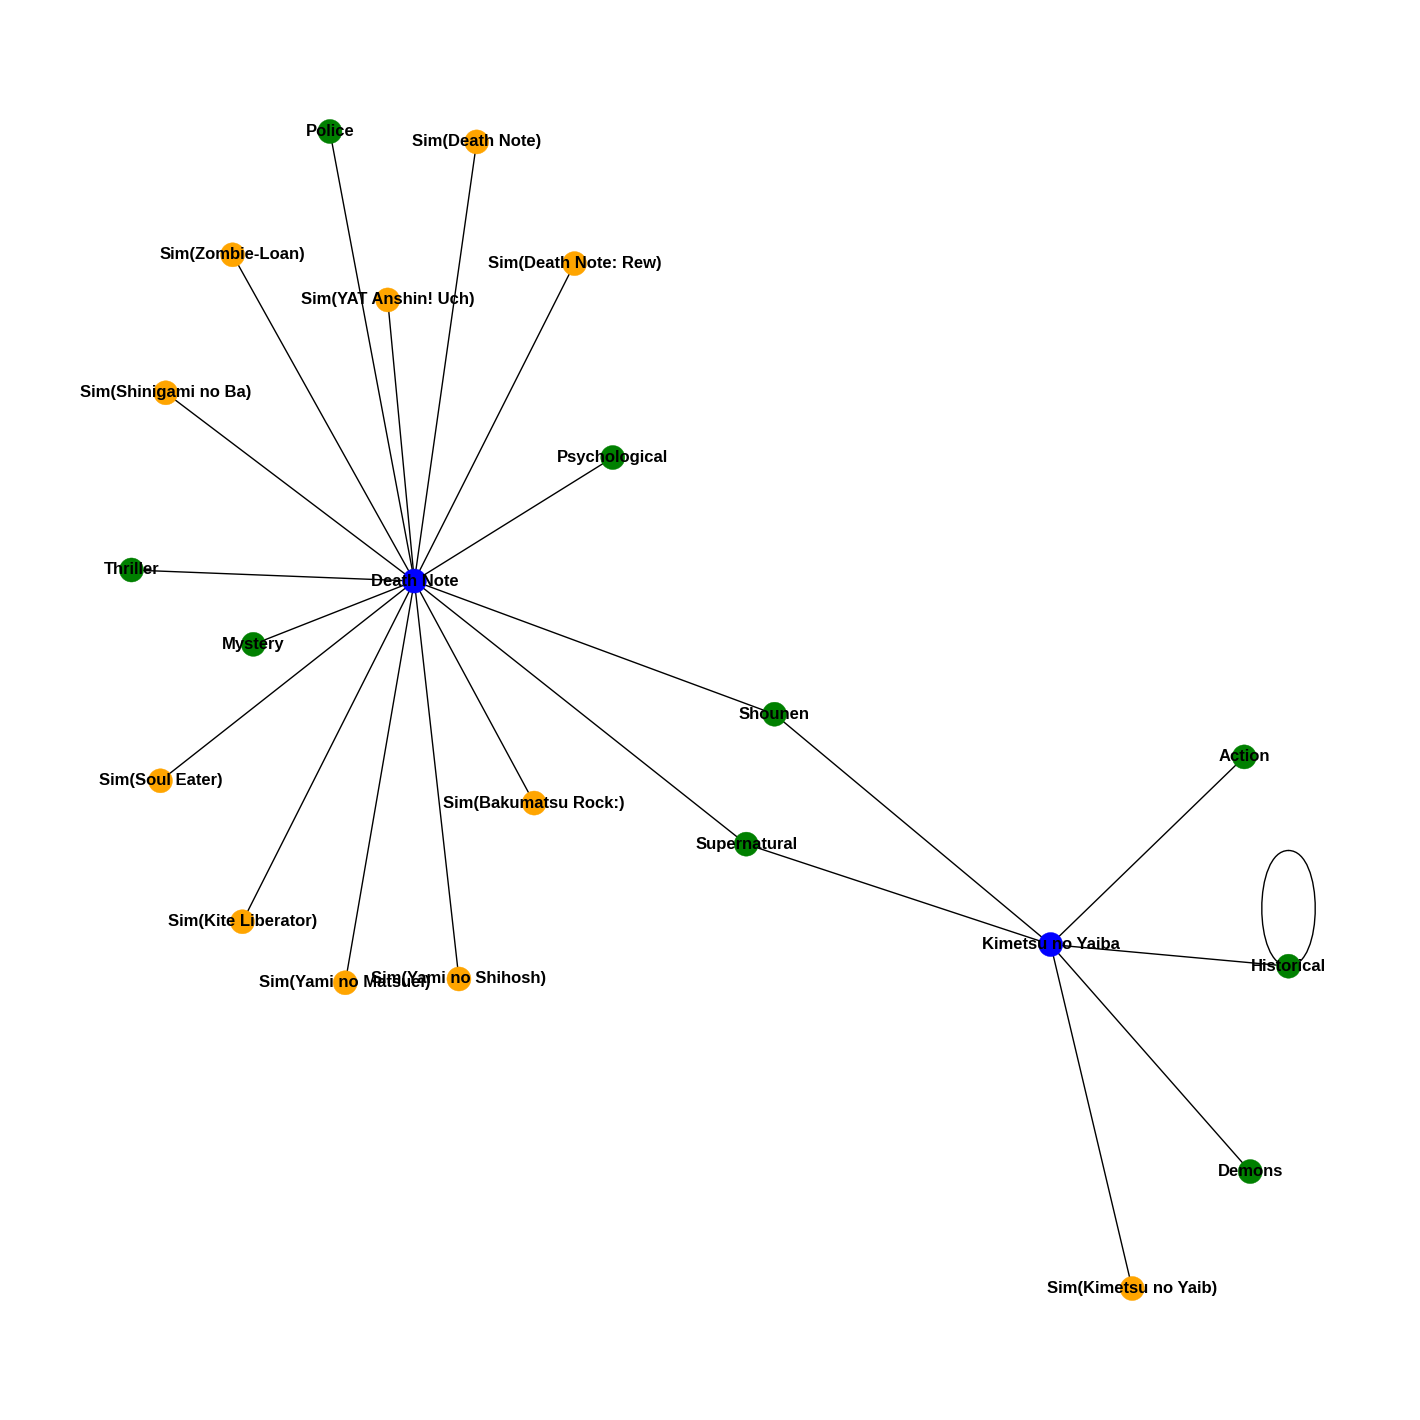

In [ ]:
list_in=["Kimetsu no Yaiba","Death Note"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calculate Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [ ]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="ANIME":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    animes=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        animes.append(key)
        weight.append(w)

    result={"ANIME":pd.Series(animes),"similarity_rate":pd.Series(np.array(weight))}
    resultdf=pd.DataFrame(result)

    #result = pd.Series(data=np.array(weight),index=animes),
    #result.sort_values(inplace=True,ascending=False)
    return resultdf;

# Let's test it ...

Which anime did you just finish watching: Gintama
****************************************************************************************************
 Anime like  Gintama 
****************************************************************************************************
                                ANIME  similarity_rate
0    Fullmetal Alchemist: Brotherhood         0.374078
1    Kizumonogatari III: Reiketsu-hen         0.123358
2                   Mob Psycho 100 II         0.240606
3                    Kimetsu no Yaiba         0.400737
4  Code Geass: Hangyaku no Lelouch R2         0.252430

Enter index of next anime you want to watch: 0
****************************************************************************************************
Fullmetal Alchemist: Brotherhood
****************************************************************************************************
Number of episodes=  64.0
RATING=  9.23
Click this for more info -->  https://myanimelist.net/anime/5114/Fullmeta

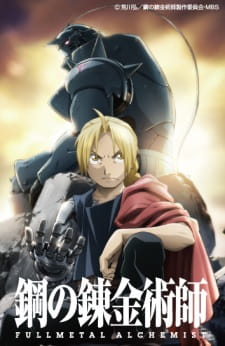

In [ ]:
a=input("Which anime did you just finish watching: ")

result1 = get_recommendation(a)

print("*"*100+"\n Anime like ",a,"\n"+"*"*100)
print(result1.head())
print()

z=int(input("Enter index of next anime you want to watch: "))

chosen_rec=result1.iloc[z,0]
print("*"*100+"\n"+chosen_rec+"\n"+"*"*100)

m=df.loc[df.title==chosen_rec]

print("Number of episodes= ",m.iloc[0,6])
print("RATING= ",m.iloc[0,10])
im=str(m.iloc[0,11])

import requests
import shutil

image_url = im
filename = image_url.split("/")[-1]
r = requests.get(image_url, stream = True)

if r.status_code == 200:
    r.raw.decode_content = True
    with open(filename,'wb') as f:
        shutil.copyfileobj(r.raw, f)

x=str(filename)

print("Click this for more info --> ",m.iloc[0,12])

from google.colab import files
from IPython.display import Image
Image(x,width=200)